In [5]:
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from feature_extraction import Blob, Words, Exclude, WordCount, POS, Readable
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from calzone import describe, lemmatize

In [20]:
data = pd.read_csv('processed_datascience1.csv.bz2')

In [7]:
import pytablewriter
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(data.head())
writer.write_table()

|  id  |  subreddit  |                                                               title                                                               |ups|                                                                    url                                                                     |created_utc|
|------|-------------|-----------------------------------------------------------------------------------------------------------------------------------|--:|--------------------------------------------------------------------------------------------------------------------------------------------|----------:|
|84zvji|r/datascience|Academic data science training programs: crowd-sourced list                                                                        |  2|https://www.reddit.com/r/datascience/comments/84zvji/academic_data_science_training_programs/                                               | 1521243666|
|84zpza|r/datascience|How to build killer Datasets, and the 6 bi

In [21]:
data[data['ups'] < 0]

,id,subreddit,title,ups,url,created_utc


In [10]:
# You can use the grab_posts module if you want to grab posts from specific subreddits and time-frames
# To retrieve your own posts requires a reddit developer account
#from calzone import grab_posts
#data = grab_posts(sub='todayilearned', start='01/24/2018', end='02/05/2018', number=30000, verbose=True)

# Data clean - 
# 1. remove '/' character
# 2. lowercase all letters
# 3. lemmatize all words - change words to their root words, ie 'wanted -> want'

data['title'] = lemmatize(data)

## Optional: Throw out outliers by including rows with Z-Scores less than 2.5 and greater than -2.5
data['z_scores'] = np.abs((data.ups-data.ups.mean())/data.ups.std())
data = data[data['z_scores']<= 2.5]

## Optional: Log transformation of up-votes
data['log_ups'] = np.log1p(data['ups'])

# Create Label column defining whether or not the article's votes exceed the average vote for the subreddit
data['gtavg'] = data.log_ups > data.log_ups.mean()

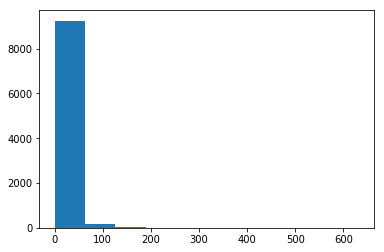

In [22]:
data.ups.hist(grid=False)

In [27]:
i = data[data.ups < 7.7]
j = data[data.ups >= 7.7]
print(i.shape)

(6579, 6)


In [4]:
print('Total Number of Titles in Dataset:', len(data['title']))
results = describe(data) # calzone function to extract title attributes
display(results)

Total Number of Titles in Dataset: 9271


,Characters,Words,Noun_Phrases,Syllables,Subjectivity,Polarity,Votes,Consonants,Vowels,Kincaid,Flesch
All,58,10,1.474275,16,0.196472,0.074312,7.719124,39,18,8,47
Success,60,11,1.530089,17,0.213003,0.086901,20.521545,41,19,8,48
Failure,57,10,1.451436,16,0.189709,0.069161,2.480620,38,18,8,46


In [8]:
import pytablewriter
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(results)
writer.write_table()

|Characters|Words|Noun_Phrases|Syllables|Subjectivity|Polarity|Votes |Consonants|Vowels|Kincaid|Flesch|
|---------:|----:|-----------:|--------:|-----------:|-------:|-----:|---------:|-----:|------:|-----:|
|        58|   10|       1.474|       16|      0.1965| 0.07431| 7.719|        39|    18|      8|    47|
|        60|   11|       1.530|       17|      0.2130| 0.08690|20.522|        41|    19|      8|    48|
|        57|   10|       1.451|       16|      0.1897| 0.06916| 2.481|        38|    18|      8|    46|



|       |Characters|Words|Noun_Phrases|Syllables|Subjectivity|Polarity|Votes |Consonants|Vowels|Kincaid|Flesch|
|------:|---------:|----:|-----------:|--------:|-----------:|-------:|-----:|---------:|-----:|------:|-----:|
|All    |        58|   10|       1.474|       16|      0.1965| 0.07431| 7.719|        39|    18|      8|    47|
|Success|        60|   11|       1.530|       17|      0.2130| 0.08690|20.522|        41|    19|      8|    48|
|Failure|        57|   10|       1.451|       16|      0.1897| 0.06916| 2.481|        38|    18|      8|    46|

In [3]:
train_X, test_X, train_y, test_y = train_test_split(data.title, 
                                                    data.gtavg, 
                                                    test_size=0.20,
                                                    random_state=25)

print('AVERAGE VOTES: ', '{:03.1f}'.format(data.ups.mean()))

# 1. Sklearn has a pipeline Class that directs the flow of model creation; 
# below the pipeline corals the features into the Random Forest classifer.
# 2. Within the pipeline is a sklearn Class called FeatureUnion.  
# 3. Feature Union allows for the joining of multiple features into a single vector
# 4. Within the feature union is a transformer list,
# containingclasses that performed the functions described above
# 5. The final pipeline item is the declaration of a classifier,
# that the combined feature vector will be inserted into

AVERAGE VOTES:  7.7


In [4]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('pipe', Pipeline([
                ('inner', FeatureUnion(
                    transformer_list=[
                        ('pos', POS()),

                        ('read', Readable()),

                        ('words', Words()),

                        ('blob', Pipeline([
                            ('all', Blob()),
                            ('minmax', MinMaxScaler()),
                        ])),
                ])),
                ('select', SelectFromModel(ExtraTreesClassifier()))

            ])),

            ('title', Pipeline([
                ('tfidf', TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', 
                                          ngram_range=(1,3), sublinear_tf=True,
                                          strip_accents='unicode', stop_words='english')),
                ('svd', TruncatedSVD(n_components=120)),
                ('normalize', MinMaxScaler(copy=False)),
                ('selector', SelectPercentile(f_classif, percentile=10))
            ])),


            ])),
    ('clf', RandomForestClassifier(n_estimators=190, n_jobs=-1, max_depth=5, max_features='log2',
                                  min_samples_leaf=1, min_samples_split=77)),
        ])

# Train model
pipeline.fit(train_X, train_y)

# Predict Test Set
y_pred = pipeline.predict(test_X)

# Save our model
joblib.dump(pipeline, 'datascience.xz', compress=('xz', 9))

# Test it out
pipeline.predict(pd.Series(['A tutorial on my machine-learning workflow \
                            for predicting whether or not this post will be popular']))

array([ True])

In [5]:
# Measure prediction Accuracy and F1 Score
accuracy = accuracy_score(y_pred=y_pred, y_true=test_y)
print('Accuracy: {:03.1f}%'.format(accuracy * 100))

print('F1 Score: {:.3f}'.format(f1_score(test_y, y_pred)))

# Cross Validate prediction Score
print('CV Scores: ', cross_val_score(pipeline, train_X, train_y, cv=5))

Accuracy: 55.9%
F1 Score: 0.525
CV Scores:  [0.57142857 0.57923129 0.54888739 0.55563048 0.54079568]
